In [1]:
#Import dependencies
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import descartes
#import pandas_profiling as pp
from geopandas.tools import overlay
from matplotlib import colors

In [2]:
#Import neighborhood mapping data (already in geojson format, so no need to convert to GeoPandas dataframe)
chicago_neighborhoods = geopandas.read_file("Data/geo_export_a7b0c29f-14bd-45d7-a251-f4277387b6a6.geojson")
chicago_neighborhoods.head(1)

,pri_neigh,sec_neigh,shape_area,shape_len,geometry
0,Grand Boulevard,BRONZEVILLE,4.849250e+07,28196.837157,POLYGON ((-87.60670812560372 41.81681377137392...


In [3]:
#Import census tract mapping data, modify column names
chicago_census = geopandas.read_file("Data/Boundaries - Census Tracts - 2010.geojson")

#Modify column names
chicago_census = chicago_census.rename(columns={"geoid10": "CENSUS_TRACT"})
chicago_census["CENSUS_TRACT"] = chicago_census["CENSUS_TRACT"].astype(np.int64)
chicago_census.head(1)

,statefp10,name10,commarea_n,namelsad10,commarea,CENSUS_TRACT,notes,tractce10,countyfp10,geometry
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,(POLYGON ((-87.62404799998049 41.7302169999839...


In [4]:
#Import data regarding food-related crimes
data_file_foodcrime = "Data/Chi_Crimes2018_Food.csv"
chicago_foodcrime = pd.read_csv(data_file_foodcrime)

#Convert dataframe into GeoPandas dataframe, define "geometry" as lat/long points of crime location
chicago_foodcrime_gdf = geopandas.GeoDataFrame(
    chicago_foodcrime, geometry=geopandas.points_from_xy(chicago_foodcrime.Longitude, chicago_foodcrime.Latitude))
chicago_foodcrime_gdf.head(1)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,geometry
0,11553488,JC101094,12/31/2018 23:45,032XX N SHEFFIELD AVE,890,THEFT,FROM BUILDING,BAR OR TAVERN,False,False,...,"(41.940518859, -87.6541242)",38.0,"4,449",57.0,731.0,25.0,22.0,5.0,28.0,POINT (-87.65412420000001 41.94051886)


In [5]:
#Import per-capita income data, modify column names and types, 
#fill NA values ("0" is best placeholder we can manage for mapping purposes)
pc_income = pd.read_csv("Data/ACS_17_5YR_B19301_with_ann.csv")
pc_income = pc_income.rename(columns={"Id2": "CENSUS_TRACT"})
pc_income = pc_income.fillna(0)
pc_income["Per capita income"] = pc_income["Per capita income"].astype(np.int64)
pc_income.head(1)

,CENSUS_TRACT,Per capita income
0,17031010100,26590


In [6]:
#Merge per capita income data with census tract mapping data
census_with_income = chicago_census.merge(pc_income, how="left", on="CENSUS_TRACT")
census_with_income.head(1)

,statefp10,name10,commarea_n,namelsad10,commarea,CENSUS_TRACT,notes,tractce10,countyfp10,geometry,Per capita income
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,(POLYGON ((-87.62404799998049 41.7302169999839...,20760


In [7]:
#Import demographic data, modify column names, merge onto census data
demographics = pd.read_csv("Data/Demographic_data.csv")
demographics = demographics.rename(columns={"Id2": "CENSUS_TRACT"})
demographics.dtypes
census_with_demo = census_with_income.merge(demographics, how="left", on="CENSUS_TRACT")
census_with_demo.head(1)

,statefp10,name10,commarea_n,namelsad10,commarea,CENSUS_TRACT,notes,tractce10,countyfp10,geometry,Per capita income,White,Black,American Indian/Alaskan Native,Asian/Pacific Islander,Hispanic/Latino
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,(POLYGON ((-87.62404799998049 41.7302169999839...,20760,0,3078,0,0,6


In [8]:
#Import grocery store data, rename column names to facilitate dataframe merge
grocery_path = "Data/Map_of_Grocery_Stores_-_2013.csv"
chicago_groceries = pd.read_csv(grocery_path)
chicago_groceries = chicago_groceries.rename(columns={"CENSUS TRACT": "CENSUS_TRACT"})
chicago_groceries.head(1)

,STORE NAME,LICENSE ID,ACCOUNT NUMBER,SQUARE FEET,BUFFER SIZE,ADDRESS,ZIP CODE,COMMUNITY AREA NAME,COMMUNITY AREA,WARD,...,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION,Community Areas,Zip Codes,Boundaries - ZIP Codes,Census Tracts,Wards,:@computed_region_awaf_s7ux
0,BOB'S LIQUORS & GROCERIES,957.0,86492.0,10001.0,A,5069 W MADISON ST,60644,AUSTIN,25,28,...,1.899505e+06,41.880296,-87.752494,"(41.8802960895, -87.7524941982)",26,22216,32,184,23,11


In [9]:
#Find count of grocery stores per census tract using "groupby" logic
grocery_group = chicago_groceries.groupby("CENSUS_TRACT").count()
grocery_count = grocery_group["STORE NAME"]

#Append grocery store per census tract count to total dataframe, remove NA values
chicago_full = census_with_demo.merge(grocery_count, how="left", on="CENSUS_TRACT")
chicago_full = chicago_full.fillna(0)

#Establish definition of "food desert" using this grocery store count
chicago_full["DesertIndicator"] = np.where(chicago_full["STORE NAME"]>0, 'Non-Food Desert', 'Food Desert')
chicago_full.head()

,statefp10,name10,commarea_n,namelsad10,commarea,CENSUS_TRACT,notes,tractce10,countyfp10,geometry,Per capita income,White,Black,American Indian/Alaskan Native,Asian/Pacific Islander,Hispanic/Latino,STORE NAME,DesertIndicator
0,17,8424,44,Census Tract 8424,44,17031842400,,842400,031,(POLYGON ((-87.62404799998049 41.7302169999839...,20760,0,3078,0,0,6,3.0,Non-Food Desert
1,17,8403,59,Census Tract 8403,59,17031840300,,840300,031,(POLYGON ((-87.6860799999848 41.82295600001154...,19664,705,66,153,886,2107,1.0,Non-Food Desert
2,17,8411,34,Census Tract 8411,34,17031841100,,841100,031,(POLYGON ((-87.62934700001182 41.8527970000265...,19802,317,154,0,6128,180,3.0,Non-Food Desert
3,17,8412,31,Census Tract 8412,31,17031841200,,841200,031,(POLYGON ((-87.68813499997718 41.8556909999909...,16387,744,421,0,113,3905,0.0,Food Desert
4,17,8390,32,Census Tract 8390,32,17031839000,,839000,031,(POLYGON ((-87.63312200003458 41.8744880000269...,60436,4960,1260,0,1291,607,0.0,Food Desert


Text(0.5, 1.0, 'Grocery Stores in Chicago')

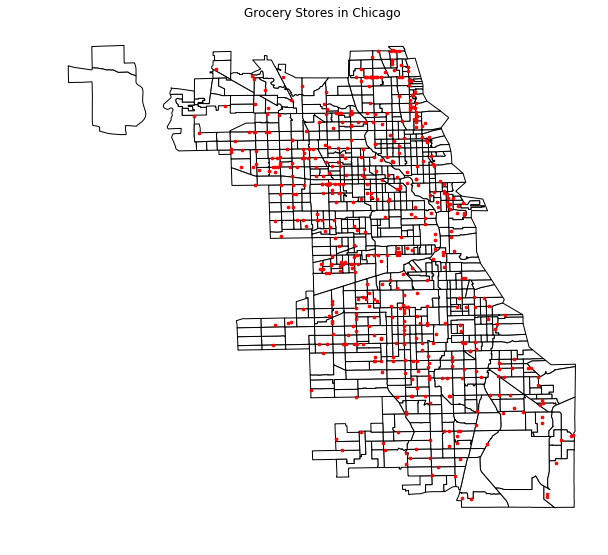

In [10]:
#Plot grocery stores in the form of points over census tracts
fig, ax = plt.subplots(1, figsize=(10,10))
ax.grid(False)
plt.axis('off')
chicago_census.plot(ax = ax, legend=True, edgecolor="black", color = 'white')
chicago_groceries_gdf = geopandas.GeoDataFrame(
    chicago_groceries, geometry=geopandas.points_from_xy(chicago_groceries.LONGITUDE, chicago_groceries.LATITUDE))
chicago_groceries_gdf.plot(ax=ax, marker="o", color="red", markersize=7)
plt.title("Grocery Stores in Chicago")
#plt.savefig('Output/GroceryStoreDots.png')

Text(0.5, 1.0, 'Food Deserts by Census Tract')

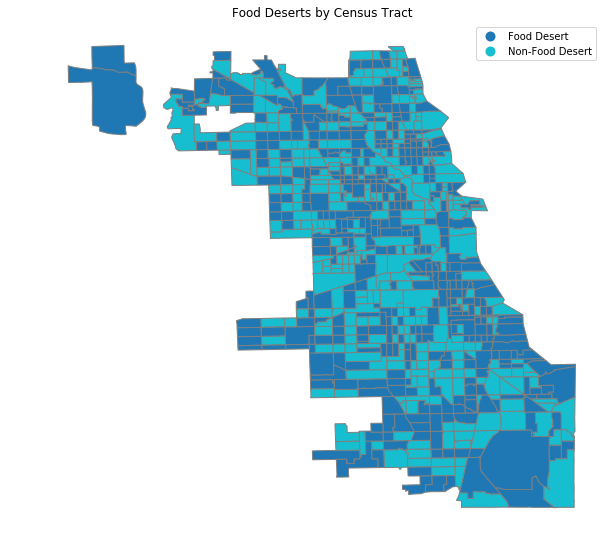

In [11]:
#Plot census tracts with food desert indicator
fig, ax = plt.subplots(1, figsize=(10,10))
ax.grid(False)
plt.axis('off')
chicago_full.plot(ax = ax, column="DesertIndicator", legend=True, edgecolor="grey")
plt.title("Food Deserts by Census Tract")

#plt.savefig('Output/Deserts.png')

Text(0.5, 1.0, 'Food Deserts by Census Tract w/Neighborhood Overlay')

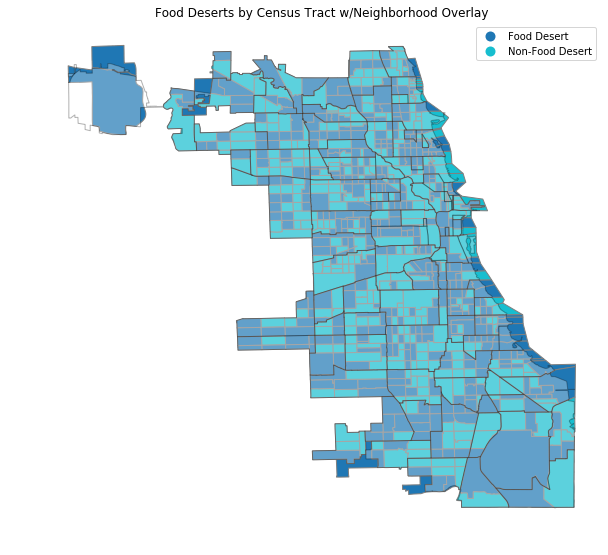

In [12]:
#Plot census tracts with food desert indicator, overlayed with neighborhoods
fig, ax = plt.subplots(1, figsize=(10,10))
ax.grid(False)
plt.axis('off')
chicago_full.plot(ax = ax, column="DesertIndicator", legend=True, edgecolor="grey")
chicago_neighborhoods.plot(ax=ax, alpha=0.3, color="white", edgecolor="black")
#chicago_subset.plot(ax=ax, marker="o", color="black", markersize=.5)
plt.title("Food Deserts by Census Tract w/Neighborhood Overlay")

#plt.savefig('Output/DesertsWithNeighborhoods.png')

Text(0.5, 1.0, 'Census Tracts w/Food-Related Crimes Overlay')

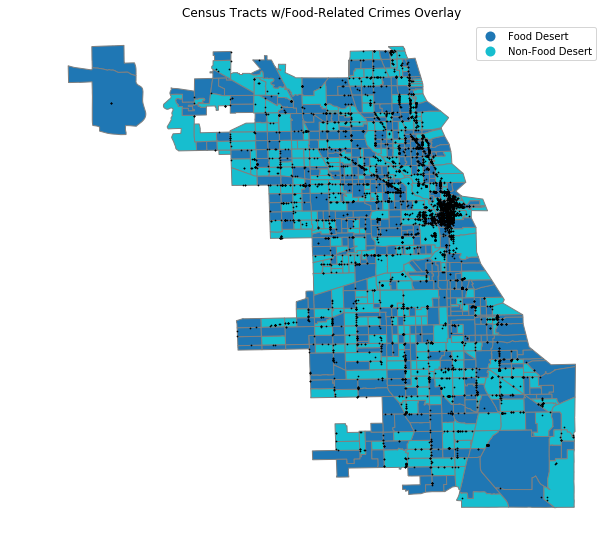

In [13]:
#Plot food-related crimes over the census tract map
fig, ax = plt.subplots(1, figsize=(10,10))
ax.grid(False)
plt.axis('off')
chicago_full.plot(ax = ax, column="DesertIndicator", legend=True, edgecolor="grey")
chicago_foodcrime_gdf.plot(ax=ax, marker="o", color="black", markersize=.5)
plt.title("Census Tracts w/Food-Related Crimes Overlay")

#plt.savefig('Output/foodcrime.png')

Text(0.5, 1.0, 'Per Capita Income over Census Tracts')

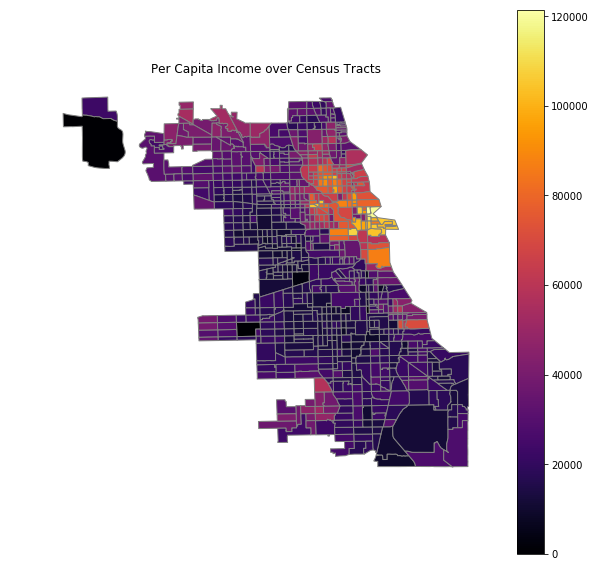

In [14]:
#Plot per capita income map
fig, ax = plt.subplots(1, figsize=(10,10))
ax.grid(False)
plt.axis('off')
chicago_full.plot(ax = ax, column="Per capita income", legend=True, edgecolor="grey", cmap = "inferno")
plt.title("Per Capita Income over Census Tracts")

#plt.savefig('Output/PerCapitaIncome.png')

Text(0.5, 1.0, 'White Population over Census Tracts')

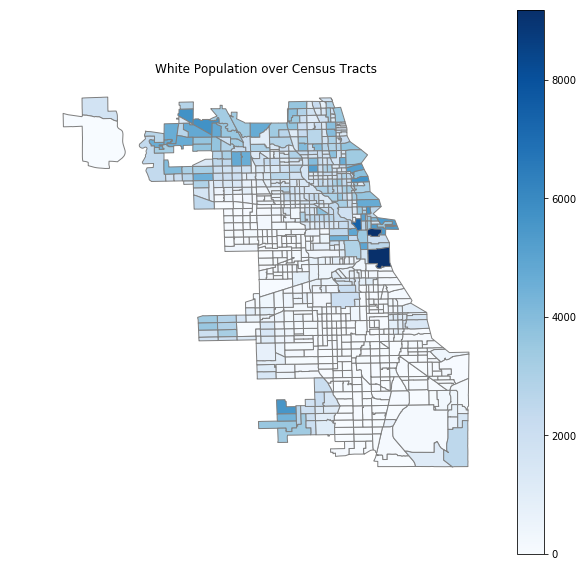

In [15]:
#Plot distribution of White population over census tracts
fig, ax = plt.subplots(1, figsize=(10,10))
ax.grid(False)
plt.axis('off')
chicago_full.plot(ax = ax, column="White", legend=True, edgecolor="grey", cmap = "Blues")
plt.title("White Population over Census Tracts")

#plt.savefig('Output/White_population.png')

Text(0.5, 1.0, 'Black Population over Census Tracts')

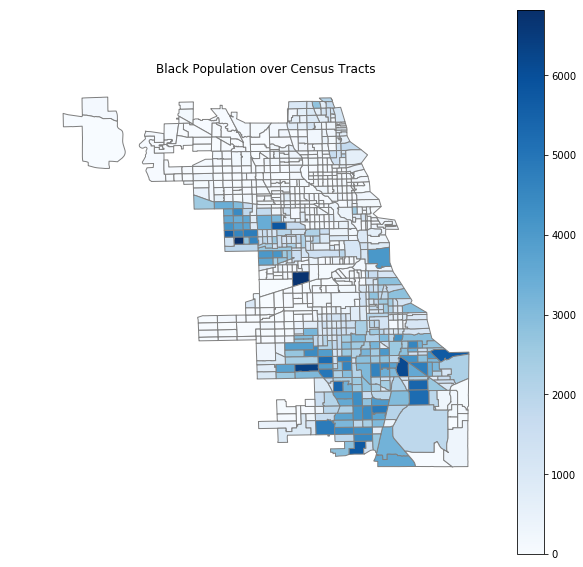

In [16]:
#Plot distribution of Black population over census tracts
fig, ax = plt.subplots(1, figsize=(10,10))
ax.grid(False)
plt.axis('off')
chicago_full.plot(ax = ax, column="Black", legend=True, edgecolor="grey", cmap = "Blues")
plt.title("Black Population over Census Tracts")

#plt.savefig('Output/Black_population.png')

Text(0.5, 1.0, 'Hispanic/Latino Population over Census Tracts')

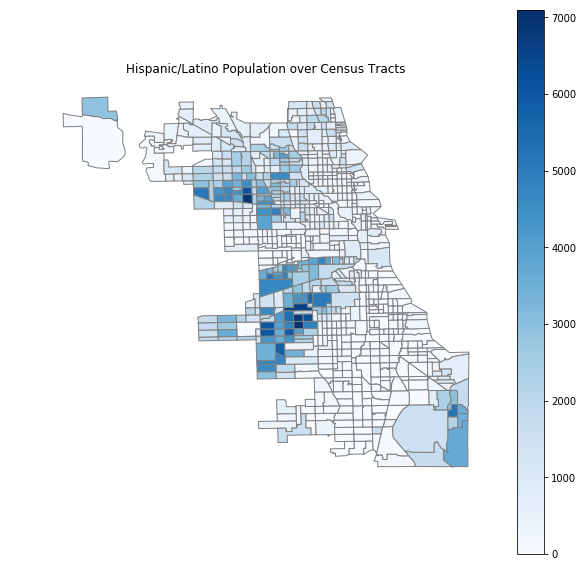

In [17]:
#Plot distribution of Hispanic/Latino population over census tracts
fig, ax = plt.subplots(1, figsize=(10,10))
ax.grid(False)
plt.axis('off')
chicago_full.plot(ax = ax, column="Hispanic/Latino", legend=True, edgecolor="grey", cmap = "Blues")
plt.title("Hispanic/Latino Population over Census Tracts")

#plt.savefig('Output/Hispanic_population.png')

Text(0.5, 1.0, 'Asian/Pacific Islander Population over Census Tracts')

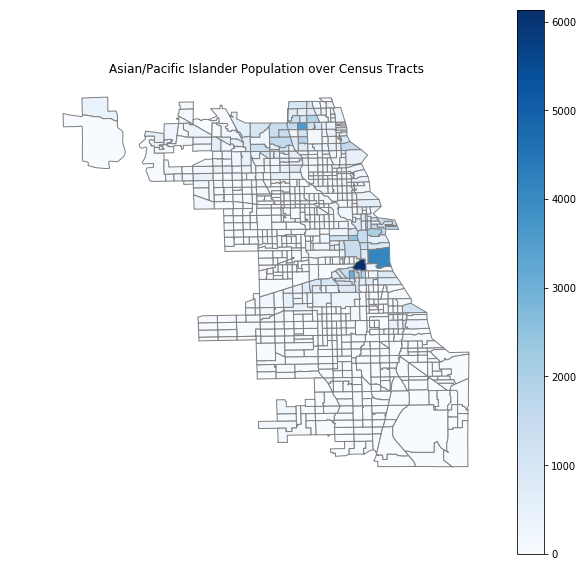

In [18]:
#Plot distribution of Asian/Pacific Islander population over census tracts
fig, ax = plt.subplots(1, figsize=(10,10))
ax.grid(False)
plt.axis('off')
chicago_full.plot(ax = ax, column="Asian/Pacific Islander", legend=True, edgecolor="grey", cmap = "Blues")
plt.title("Asian/Pacific Islander Population over Census Tracts")

#plt.savefig('Output/Asian_population.png')

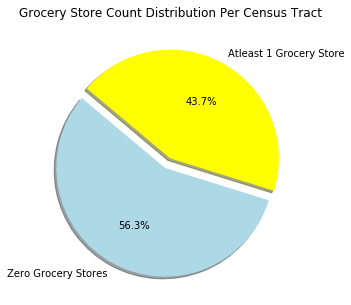

In [19]:
#Pie chart parameters
colors = ["lightblue", "yellow"]
explode = (0.1, 0)

#Pie chart - Deserts 
fig, ax = plt.subplots(1, figsize=(5,5))
chicago_full["Grocery Category"] = np.where(chicago_full["STORE NAME"]>0, "Atleast 1 Grocery Store", "Zero Grocery Stores")
grocery_count = chicago_full["Grocery Category"].value_counts()
labels = ["Zero Grocery Stores", "Atleast 1 Grocery Store"]
plt.pie(grocery_count, explode=explode, colors=colors, autopct="%1.1f%%", shadow=True, labels=labels, startangle=140)
plt.title("Grocery Store Count Distribution Per Census Tract")
plt.savefig('Output/DesertPie1.png')

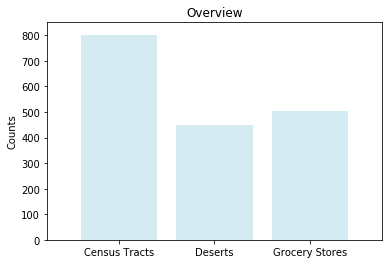

In [20]:
#Bar chart count census, grocery, deserts
counts = [801, 451, 506]
x_axis = np.arange(len(counts))
#ax.grid(False)

plt.bar(x_axis, counts, color='lightblue', alpha=0.5, align="center")
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, ["Census Tracts", "Deserts", "Grocery Stores"])
plt.xlim(-0.75, len(x_axis)-0.25)
plt.ylim(0, max(counts)+50)
plt.title("Overview")
plt.ylabel("Counts")


plt.savefig('Output/OverviewBar.png')
plt.show()

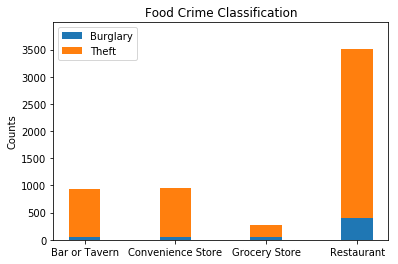

In [21]:
#Crime Stacked Bar Chart
N = 4
Burglary = (43, 57, 52, 406)
Theft = (892, 904, 220, 3102)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, Burglary, width)
p2 = plt.bar(ind, Theft, width,
             bottom=Burglary)

#plt.ylim(0, max(Theft)+50)

plt.ylabel('Counts')
plt.title('Food Crime Classification')
plt.xticks(ind, ('Bar or Tavern', 'Convenience Store', 'Grocery Store', 'Restaurant'))
plt.yticks(np.arange(0, 4000, 500))
plt.legend((p1[0], p2[0]), ('Burglary', 'Theft'))
#plt.legend((loc='best'), ('Burglary', 'Theft'))
plt.ylim([0,4000])

plt.show()

In [22]:
plt.savefig('Output/CrimeBar.png')

<Figure size 432x288 with 0 Axes>